# IT3212 - Assignment 2

## Setup

### Importing libraries

In [193]:
# Standard libraries
import numpy as np  
import pandas as pd
import re
import string

# NLTK tools and datasets
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Uncomment if you need to download NLTK data packages
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Miscellaneous
from collections import Counter
from urllib.parse import unquote
from textblob import TextBlob
import contractions
from scipy import stats
import chardet

### Fix dataset encoding issues

In [194]:
# Some rows in the raw data include non UTF-8 characters. 

# Example of text with non UTF-8 characters:
# 778245336,FALSE,finalized,5,8/30/15 13:27,Not Relevant,0.7952,,army,
# text column: Pakistan,".: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo Indian Army ki��_ http://t.co/WJLJq3yA4g"
# ,6.29079E+17,195397186

# Chardet identifies the encoding of the raw data as 'MacRoman'.
# For now, we will remove all non UTF-8 characters from the raw data
# We handle this by removing all � characters from the raw data and writing the modified content back to the file.

def fix_non_utf8_encoding(filepath, destination_filepath):
    with open(filepath, 'rb') as file:
        rawdata = file.read()
        result = chardet.detect(rawdata)
        print(result['encoding'])


    # Open the file in read mode, read its contents, then close it
    with open('data/disaster-tweets.csv', 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Remove all � characters
    content = content.replace('�', '')

    # Open the file in write mode and write the modified content back to it
    with open(destination_filepath, 'w', encoding='utf-8') as file:
        file.write(content)

filepath = 'data/disaster-tweets.csv'
dest = 'data/disaster-tweets-utf8.csv'

# fix_non_utf8_encoding(filepath, dest)

In [195]:
def split_train_test(filepath, destination_filepath_train, destination_filepath_test):
    df = pd.read_csv(filepath, encoding='utf-8')
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    train_data.to_csv(destination_filepath_train, index=False)
    test_data.to_csv(destination_filepath_test, index=False)

filepath = 'data/disaster-tweets-utf8.csv'
dest_train = 'data/train.csv'
dest_test = 'data/test.csv'

# split_train_test(filepath, dest_train, dest_test)

In [196]:
# Dataframe with data to be used in training
df = pd.read_csv('./data/train.csv', encoding='utf-8')
df_test = pd.read_csv('./data/train.csv', encoding='utf-8')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just rem...,6.291070e+17,2.327739e+08
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishi...,6.290180e+17,2.750220e+07
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIx...,6.290920e+17,6.052387e+08
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exch...,6.291190e+17,2.305930e+09
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,6.290800e+17,2.464266e+07


## Feature extraction before preprocessing

Some extracted features of interest must be done before preprocessing any data. These features are:

- `hashtag_count`: number of hashtags in the tweet
- `mention_count`: number of mentions in the tweet
- `has_url`: whether the tweet contains a URL

In [197]:
# Extract the number of hashtags
df["hashtag_count"] = df["text"].apply(lambda x: len([c for c in str(x) if c == "#"]))

# Extract the number of mentions
df["mention_count"] = df["text"].apply(lambda x: len([c for c in str(x) if c == "@"]))

# Extract the `has_url` feature
df["has_url"] = df["text"].apply(lambda x: 1 if "http" in str(x) else 0)

# Write the updated dataframe to a CSV file
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid,hashtag_count,mention_count,has_url
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just rem...,6.291070e+17,2.327739e+08,0,0,0
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishi...,6.290180e+17,2.750220e+07,0,1,0
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIx...,6.290920e+17,6.052387e+08,0,0,1
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exch...,6.291190e+17,2.305930e+09,0,0,1
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,6.290800e+17,2.464266e+07,0,0,1


##  Exploratory data analysis (EDA)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid,hashtag_count,mention_count,has_url
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just rem...,6.291070e+17,2.327739e+08,0,0,0
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishi...,6.290180e+17,2.750220e+07,0,1,0
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIx...,6.290920e+17,6.052387e+08,0,0,1
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exch...,6.291190e+17,2.305930e+09,0,0,1
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,6.290800e+17,2.464266e+07,0,0,1


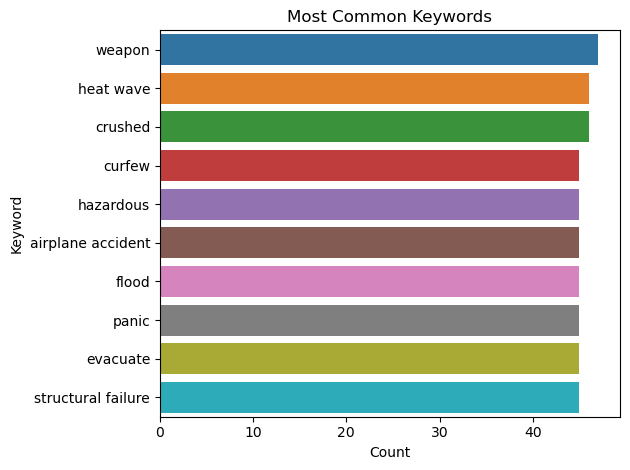

In [198]:
# Clean `keyword` column.
def clean_keyword(keyword: str):
    return unquote(keyword) if pd.notnull(keyword) else ''

df['keyword'] = df['keyword'].apply(clean_keyword).apply(str.lower)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/02-clean-keywords.csv', index=False)
display(df.head())

# Plot the most common keywords

defined_keywords = df[df['keyword'] != '']['keyword']

plt.figure()
sns.countplot(y=defined_keywords, order=defined_keywords.value_counts().iloc[:10].index)
plt.title('Most Common Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.tight_layout()
plt.savefig('./results/03-keywords.png')
plt.show()



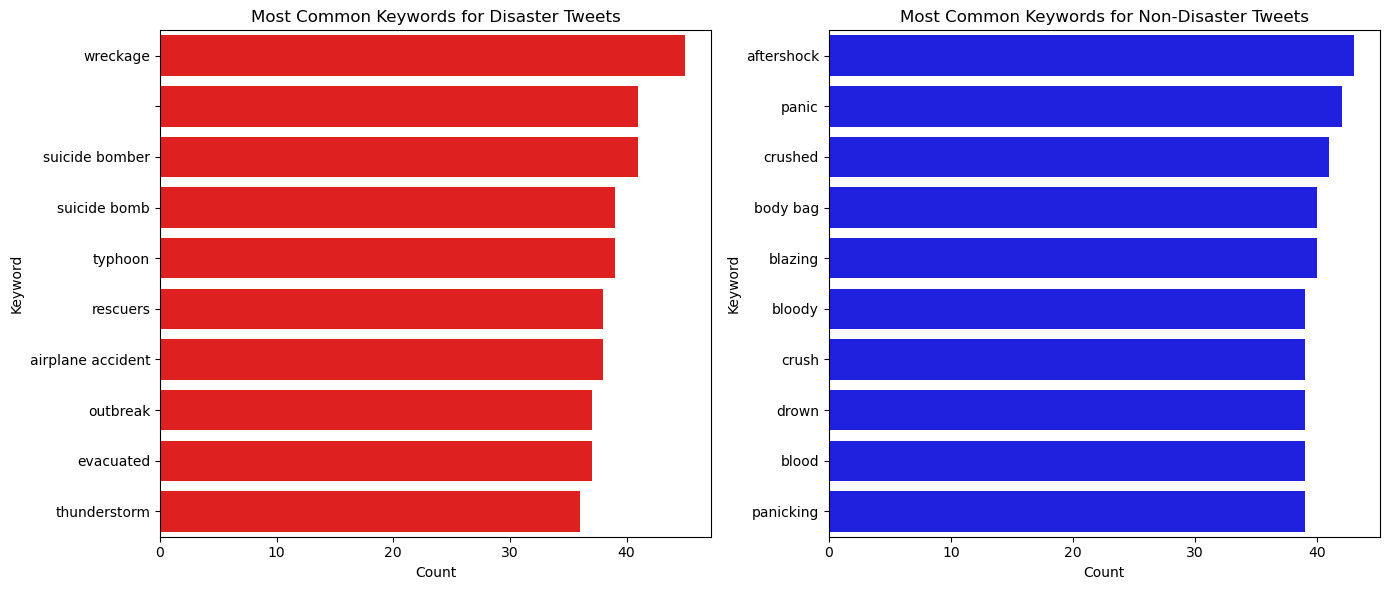

In [199]:
# Compare keywords for disaster tweets and non-disaster tweets
disaster_keywords = df[df['choose_one'] == 'Relevant']['keyword']
non_disaster_keywords = df[df['choose_one'] == 'Not Relevant']['keyword']

# Create a figure object and define the grid
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting
sns.countplot(y=disaster_keywords, ax=ax[0], order=disaster_keywords.value_counts().iloc[:10].index, color='red')
sns.countplot(y=non_disaster_keywords, ax=ax[1], order=non_disaster_keywords.value_counts().iloc[:10].index, color='blue')

# Titles and labels
ax[0].set_title('Most Common Keywords for Disaster Tweets')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Keyword')

ax[1].set_title('Most Common Keywords for Non-Disaster Tweets')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Keyword')

# Adjust layout
plt.tight_layout()
plt.savefig('./results/keywords_comparison.png')
plt.show()



In the plot above, we can see that the top 10 shared keywords of disaster-related tweets and non-disaster-related tweets do not share any common keywords.

Text(0.5, 1.0, 'Number of Tweets with Target Value of 1 and 0')

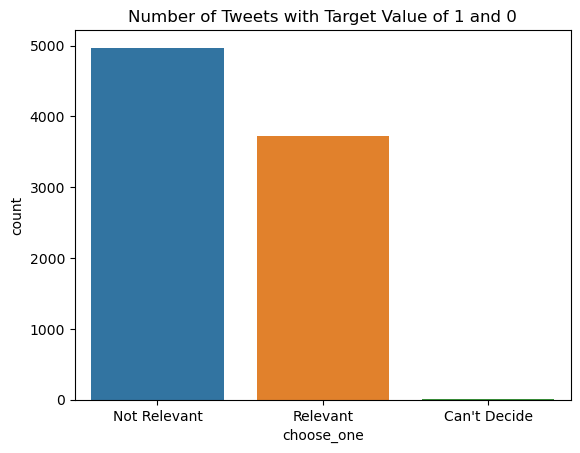

In [200]:
sns.countplot(x='choose_one', data=df)
plt.title('Number of Tweets with Target Value of 1 and 0')

## 1. Preprocessing

### Remove entries with low confidence in labling

In [201]:
initial_count = df.shape[0]
# Remove rows with a confidence score less than 1.0
confidence_threshold = 0.7
df = df[df['choose_one:confidence'] >= confidence_threshold]
df = df[df['choose_one'] != "Can't Decide"]

print("Number of rows removed: {}".format(initial_count - df.shape[0]))

Number of rows removed: 2167


All entries with can't decide belonged in the set with confidence under treshold 

### 1.1 Delete features that are not useful

In [202]:
# original_features: _unit_id, _golden, _unit_state, _trusted_judgments, _last_judgment_at, choose_one, choose_one:confidence, choose_one_gold, keyword, location, text, tweetid, userid
features_to_keep = ['y', 'text']

# map choose one to 1 or 0, call it y to be consistent with ml conventions
df['y'] = df['choose_one'].apply(lambda x: 1 if x == 'Relevant' else 0)
df = df[features_to_keep]

df_test['y'] = df_test['choose_one'].apply(lambda x: 1 if x == 'Relevant' else 0)
df_test = df_test[features_to_keep]

display(df.head())

,y,text
0,0,i dont even remember slsp happening i just rem...
1,0,@hazelannmac ooh now I feel guilty about wishi...
2,0,Soultech - Collide (Club Mix) http://t.co/8xIx...
3,1,Police Officer Wounded Suspect Dead After Exch...
4,0,Cramer: Iger's 3 words that wrecked Disney's s...


### 1.2 Text processing

In [203]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def clean_text(text: str):
  text = re.sub(r'https?://\S+', '', text)  # Remove links
  text = re.sub(r'\n', ' ', text)  # Remove line breaks
  text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
  text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
  text = contractions.fix(text)
  text = tokenizer.tokenize(text)
  text = ' '.join(text)

  return text

# show head of text column
display(df['text'])

df['text'] = df['text'].apply(lambda x: clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))
df.head()

0       i dont even remember slsp happening i just rem...
1       @hazelannmac ooh now I feel guilty about wishi...
2       Soultech - Collide (Club Mix) http://t.co/8xIx...
3       Police Officer Wounded Suspect Dead After Exch...
4       Cramer: Iger's 3 words that wrecked Disney's s...
                              ...                        
8695    How is it one careless match can start a fores...
8696    Govt allocating 1.3 bn for flood action: Issue...
8697    Last night was a ball! Atop a 40 ft. fire truc...
8698    Thank you @FedEx for no longer shipping live m...
8699    #Japan #Fukushima the most serious man made di...
Name: text, Length: 6533, dtype: object

,y,text
0,0,do not even remember slsp happening remember l...
1,0,hazelannmac ooh feel guilty wishing hatman bet...
2,0,soultech collide club mix
3,1,police officer wounded suspect dead exchanging...
4,0,cramer igers 3 word wrecked disney stock


### 1.4 Duplicated data

In [204]:
count_initial = df.shape[0]

# Remove duplicated rows with respect to the `text` column
df = df.drop_duplicates(subset=['text'])

print("Removed {} duplicated rows.".format(count_initial - df.shape[0]))

Removed 638 duplicated rows.


## 2. Extracting features

In [205]:
# Create new column for text length
df['text_length'] = df['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

In [206]:

# def get_polarity(text: str):
#     return TextBlob(text).sentiment.polarity

# def get_subjectivity(text: str):
#     return TextBlob(text).sentiment.subjectivity

# # Add new features for polarity and subjectivity
# df['polarity'] = df['text'].apply(get_polarity)
# df['subjectivity'] = df['text'].apply(get_subjectivity)

# df_test['polarity'] = df_test['text'].apply(get_polarity)
# df_test['subjectivity'] = df_test['text'].apply(get_subjectivity)

## Sentiment analysis


In [207]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return "Positive"
    elif sentiment_scores['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['text'].apply(analyze_sentiment_vader)

df.sentiment.head()

## Checking if sentiment and target is correlated


In [208]:

from scipy import stats


df['sentiment_numeric'] = df['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

disaster_group = df[df['target'] == 1]['sentiment_numeric']
not_disaster_group = df[df['target'] == 0]['sentiment_numeric']

t_statistic, p_value = stats.ttest_ind(disaster_group, not_disaster_group, equal_var=False)

print(p_value)
if p_value < 0.05:
    print("There is a significant difference in sentiment between disaster and not disaster tweets.")
else:
    print("There is no significant difference in sentiment between disaster and not disaster tweets.")

## Create ngrams

In [209]:
def create_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return n_grams


df['bigrams'] = df['text'].apply(lambda x: create_ngrams(x, 2))
df['trigrams'] = df['text'].apply(lambda x: create_ngrams(x, 3))

df_test['bigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 2))
df_test['trigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 3))


## Count number of occurences of ngrams in each category


### Bigrams

In [210]:

disaster_bigrams = df[df['y'] == 1]['bigrams']
non_disaster_bigrams = df[df['y'] == 0]['bigrams']

disaster_bigram_counts = Counter([gram for ngram_list in disaster_bigrams for gram in ngram_list])
non_disaster_bigram_counts = Counter([gram for ngram_list in non_disaster_bigrams for gram in ngram_list])

print("Most common n-grams in disaster-related tweets:")
print(disaster_bigram_counts.most_common(10))


print("\nMost common n-grams in non-disaster tweets:")
print(non_disaster_bigram_counts.most_common(10))

Most common n-grams in disaster-related tweets:
[(('suicide', 'bomber'), 47), (('do', 'not'), 34), (('i', 'am'), 33), (('severe', 'thunderstorm'), 32), (('suicide', 'bombing'), 28), (('wild', 'fire'), 28), (('thunderstorm', 'warning'), 26), (('heat', 'wave'), 25), (('northern', 'california'), 24), (('70', 'year'), 22)]

Most common n-grams in non-disaster tweets:
[(('i', 'am'), 230), (('do', 'not'), 126), (('can', 'not'), 77), (('you', 'are'), 74), (('going', 'to'), 41), (('youtube', 'video'), 30), (('i', 'have'), 30), (('that', 'is'), 30), (('liked', 'youtube'), 29), (('look', 'like'), 28)]


### Trigrams

In [211]:
disaster_trigrams = df[df['y'] == 1]['trigrams']
non_disaster_trigrams = df[df['y'] == 0]['trigrams']

disaster_trigram_counts = Counter([gram for ngram_list in disaster_trigrams for gram in ngram_list])
non_disaster_trigram_counts = Counter([gram for ngram_list in non_disaster_trigrams for gram in ngram_list])

print("Most common trigrams in disaster-related tweets:")
print(disaster_trigram_counts.most_common(10))


print("\nMost common trigrams in non-disaster tweets:")
print(non_disaster_trigram_counts.most_common(10))

Most common trigrams in disaster-related tweets:
[(('severe', 'thunderstorm', 'warning'), 26), (('suicide', 'bomber', 'kill'), 17), (('suicide', 'bomber', 'detonated'), 17), (('pkk', 'suicide', 'bomber'), 15), (('bomber', 'detonated', 'bomb'), 15), (('northern', 'california', 'wildfire'), 15), (('officer', 'wounded', 'suspect'), 14), (('16yr', 'old', 'pkk'), 14), (('old', 'pkk', 'suicide'), 14), (('detonated', 'bomb', 'turkey'), 14)]

Most common trigrams in non-disaster tweets:
[(('liked', 'youtube', 'video'), 29), (('i', 'am', 'going'), 20), (('pick', 'fan', 'army'), 16), (('likely', 'rise', 'top'), 14), (('rise', 'top', 'pay'), 14), (('top', 'pay', 'pile'), 14), (('do', 'not', 'know'), 13), (('ignition', 'knock', 'detonation'), 12), (('cross', 'body', 'bag'), 12), (('deluged', 'invoice', 'make'), 11)]


In [212]:
# print features
display(df.columns)

Index(['y', 'text', 'text_length', 'bigrams', 'trigrams'], dtype='object')

### Encode text

In [219]:
# Using TF-IDF Vectorizer 

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the training data
embeddings = vectorizer.fit_transform(df['text'])

# Transform the test data using the same vectorizer
embeddings_test = vectorizer.transform(df_test['text'])

# Index(['y', 'text', 'text_length', 'polarity', 'subjectivity', 'sentiment',
    #    'bigrams', 'trigrams'],

# keep features: y, text, text_length

df = df[['y', 'text', 'text_length']]
df_test = df_test[['y', 'text', 'text_length']]

# Concatenate the embeddings with the original dataframes
# Create dataframes from embeddings with aligned indices
embeddings_df = pd.DataFrame(embeddings.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
embeddings_test_df = pd.DataFrame(embeddings_test.toarray(), columns=vectorizer.get_feature_names_out(), index=df_test.index)

# Concatenate the dataframes with the embeddings
df_with_embeddings = pd.concat([df, embeddings_df], axis=1)
df_test_with_embeddings = pd.concat([df_test, embeddings_test_df], axis=1)

## 3. Selecting features

> TODO: Select features from the extracted features

In [220]:
print(df.isnull().sum())
print("--------------------------")
print(df_test.isnull().sum())
print("--------------------------")

print(df_with_embeddings.isnull().sum())
print("--------------------------")
print(df_test_with_embeddings.isnull().sum())
print("--------------------------")

y              0
text           0
text_length    0
dtype: int64
--------------------------
y              0
text           0
text_length    0
dtype: int64
--------------------------
y              0
text           0
text_length    0
05             0
10             0
              ..
yet            0
york           0
you            0
youtube        0
zone           0
Length: 1003, dtype: int64
--------------------------
y              0
text           0
text_length    0
05             0
10             0
              ..
yet            0
york           0
you            0
youtube        0
zone           0
Length: 1003, dtype: int64
--------------------------


In [228]:
y_train = df_with_embeddings['y']
X_train = df_with_embeddings.drop(['text', 'y'], axis=1)

# split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_test = df_test_with_embeddings['y']
X_test = df_test_with_embeddings.drop(['text', 'y'], axis=1)

## 4. Modelling

#### 4.1.1. Logistic regression

In [233]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

logreg = LogisticRegression(random_state=42, solver="liblinear")

logreg.fit(X_train, y_train)

y_val_pred = logreg.predict(X_val)

Validation Accuracy: 0.8396946564885496
Validation Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.92      0.88       724
           1       0.85      0.71      0.77       455

    accuracy                           0.84      1179
   macro avg       0.84      0.82      0.82      1179
weighted avg       0.84      0.84      0.84      1179



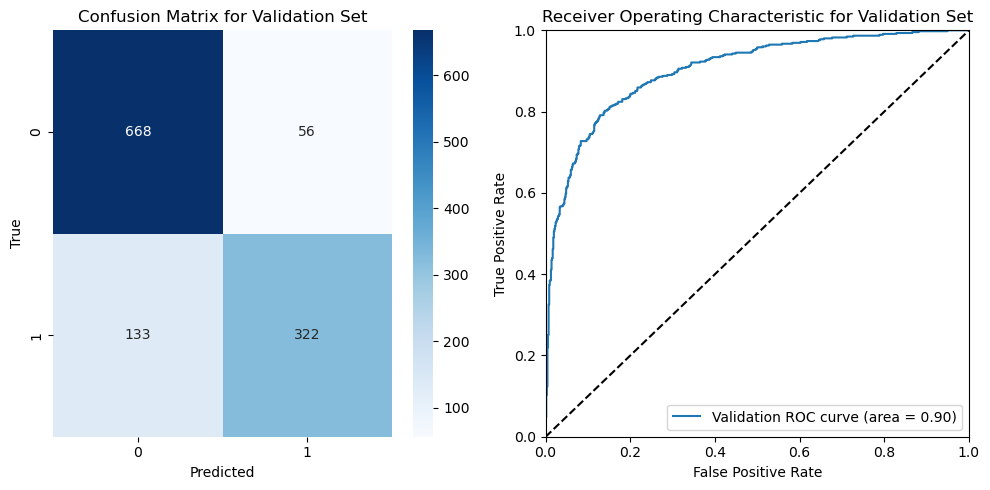

Accuracy: 0.8101149425287356
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      4984
           1       0.86      0.67      0.75      3716

    accuracy                           0.81      8700
   macro avg       0.82      0.79      0.80      8700
weighted avg       0.82      0.81      0.81      8700



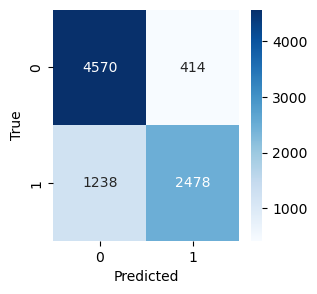

In [239]:
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")

print(f"Validation Classification Report: \n {classification_report(y_val, y_val_pred)}")

cm_val = confusion_matrix(y_val, y_val_pred)
# Compute ROC curve for validation set
false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, logreg.predict_proba(X_val)[:, 1])

# AUC for validation set
area_under_curve_for_roc_val = auc(false_positive_rate_val, true_positive_rate_val)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot confusion matrix on the first axis
sns.heatmap(cm_val, annot=True, fmt='g', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix for Validation Set')

# Plot ROC curve on the second axis
axes[1].plot(false_positive_rate_val, true_positive_rate_val, label='Validation ROC curve (area = %0.2f)' % area_under_curve_for_roc_val)
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic for Validation Set')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Predictions
y_pred = logreg.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification Report
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### 4.1.2. Support Vector Machines

Accuracy: 0.8214942528735633
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85      4984
           1       0.85      0.70      0.77      3716

    accuracy                           0.82      8700
   macro avg       0.83      0.81      0.81      8700
weighted avg       0.82      0.82      0.82      8700

Confusion Matrix: 
 [[4528  456]
 [1097 2619]]


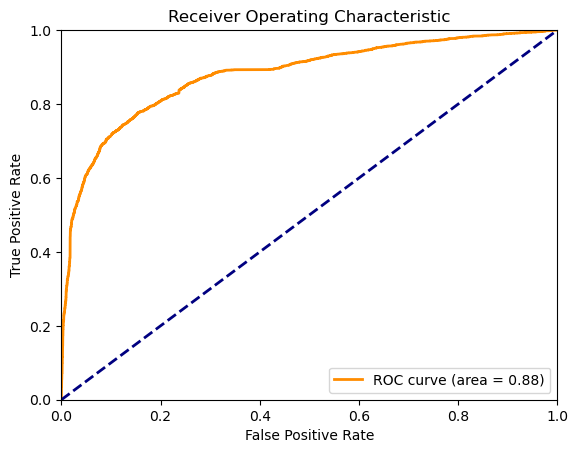

In [225]:

# Initialize SVM model
svm_model = SVC(kernel='linear', C=1, random_state=42, probability=True)

# Fit the model
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")

# Predict probabilities
y_prob = svm_model.predict_proba(X_test)[:,1]

# Compute ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4.2. With hyperparameter tuning

#### 4.2.1. Logistic regression

In [ ]:

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
print("Accuracy after GridSearchCV: ", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anacon

Best parameters: {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy after GridSearchCV:  0.8468061051441492


/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### 4.2.2. Support Vector Machines

In [ ]:
# Define hyperparameters and their possible values
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search_svm.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search_svm.best_params_}")

# Evaluate on the test set
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)
print("Accuracy after GridSearchCV: ", accuracy_score(y_test, y_pred_svm))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy after GridSearchCV:  0.8434143583945732
